In [158]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import json 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import ast
from plotting import *
from sklearn.metrics import f1_score, roc_curve
from pylab import *
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load Data


In [123]:
df = pd.read_csv('../results/task_results_final.csv')
print(df.columns)


Index(['seed_id', 'single_experiment_id', 'task', 'task_name', 'technique',
       'technique_name', 'model', 'model_name', 'n_train', 'balanced_train',
       'balanced_eval', 'template', 'template_name', 'seed', 'eval_set',
       'eval_true', 'eval_pred', 'f1', 'acc', 'prec', 'recall',
       'train_runtime', 'datetime'],
      dtype='object')


# Data Cleaning

In [125]:
print('\n---Pct of NaN in df columns---')
null_cols = []
for c in df.columns:
    num_na = sum(pd.isna(df[c])==True)
    if num_na !=0:
        null_cols.append(c)
    print(f"{c}: {np.round(num_na/len(df[c]),2)}%")

# Remove duplicate columns (correct results stored in ['acc', 'prec', 'recall', 'f1])
# TODO remove these things in processing_results.ipynb before 
# drop_cols = ['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_cm (tn, fp, fn, tp)']
# df = df.drop(drop_cols, axis = 1)


---Pct of NaN in df columns---
seed_id: 0.0%
single_experiment_id: 0.0%
task: 0.0%
task_name: 0.0%
technique: 0.0%
technique_name: 0.0%
model: 0.0%
model_name: 0.0%
n_train: 0.0%
balanced_train: 0.0%
balanced_eval: 0.0%
template: 0.41%
template_name: 0.0%
seed: 0.02%
eval_set: 0.01%
eval_true: 0.0%
eval_pred: 0.0%
f1: 0.0%
acc: 0.0%
prec: 0.0%
recall: 0.0%
train_runtime: 0.0%
datetime: 0.01%


In [126]:
# Model Names
print('\n----MODELS----')
print(f"Original model names:\n{df['model'].value_counts()}")
model_mapping = {'distilbert':'DistilBERT', 'gpt2': 'GPT-2', 'gpt3.0': 'GPT-3', 'gpt3.5': 'GPT-3.5', 'gpt4': 'GPT-4',
                 'distilbert-base-cased':'DistilBERT',
                 'microsoft/deberta-v3-base':'DeBERTa-v3',
                 'LabelModel': 'LabelModel',
                 'NB': 'Naive Bayes'}

df['model_name'] = df['model'].map(lambda x: model_mapping[x])

print(f"\nReplaced model names:\n{df['model_name'].value_counts()}")

print(f"\nPer technique model counts:")
for i in df['technique'].unique():
    print(f"\nTechnique: {i}\n{df['model_name'][df['technique']==i].value_counts()}")

# Techniques
print('\n----TECHNIQUES----')
print(f"Original technique names:\n{df['technique'].value_counts()}")
technique_mapping = {'prompt_engineering':'Prompt_Engineering',
                 'transfer_learning':'Transfer_Learning',
                 'naive_bayes':'Naive_Bayes',
                 'weak_supervision': 'Weak_Supervision',
                 'zero_shot_prompt_engineering': 'Zero_Shot_Prompt_Engineering',
                 'Weak_Supervision': 'Weak_Supervision',
                 'Prompt_Engineering': 'Prompt_Engineering',
                 'Transfer_Learning':'Transfer_Learning',
                 'Zero_Shot_Prompt_Engineering':'Zero_Shot_Prompt_Engineering',
                 'Naive_Bayes': 'Naive_Bayes'}

df['technique'] = df['technique'].map(lambda x: technique_mapping[x])
df['technique_name'] = df['technique'].map(lambda x: x.replace('_', " ").title())

print(f"\nReplaced technique names:\n{df['technique_name'].value_counts()}")

# Tasks
print('\n----Tasks----')
print(f"Original task names:\n{df['task'].value_counts()}")
task_mapping = {'binary_abuse':'Binary Abuse',
                 'binary_movie_sentiment':'Binary Movie Sentiment',
                 'Binary Movie Sentiment': 'Binary Movie Sentiment',
                 'Binary Abuse':'Binary Abuse'}
df['task'] = df['task'].map(lambda x: task_mapping[x])
df['task_name'] = df['task'].map(lambda x: x.replace('_', " ").title())

print(f"\nReplaced task names:\n{df['task_name'].value_counts()}")

# Tasks
print('\n----Prompt Templates----')
print(f"Original prompt names:\n{df['template'].value_counts()}")

prompt_dict = {'Binary Abuse': {
                                np.nan:'NAN',
                                '{"placeholder":"text_a"} Is this text abusive? {"mask"}':'Prompt 1: Is this text abusive?',
                                '{"placeholder":"text_a"} Does this text contain abuse? {"mask"}': 'Prompt 2: Does this text contain abuse?',
                                '{"placeholder":"text_a"} It was? {"mask"}' :'Prompt 3: It was? Abusive or Not Abusive',
                                'Using one word, does the internet comment contain toxic language, Yes or No?': 'Using one word, does the internet comment contain toxic language, Yes or No?',
                                'Using one word, is this internet comment using toxic language, Yes or No?': 'Using one word, is this internet comment using toxic language, Yes or No?',
                                'You are a researcher who needs to classify comments on the internet as containing abusive language or not containing abusive language. Using one word, does the internet comment contain abusive language, Yes or No?': 'You are a researcher who needs to classify comments on the internet as containing abusive language or not containing abusive language. Using one word, does the internet comment contain abusive language, Yes or No?',
                                },
                'Binary Movie Sentiment' : {
                                np.nan:'NAN',
                                '{"placeholder":"text_a"} Is this text negative? {"mask"}': 'Prompt 1: Is this text negative?',
                                '{"placeholder":"text_a"} Does this text contain negative sentiment? {"mask"}': 'Prompt 2: Does this text contain negative sentiment?',
                                '{"placeholder":"text_a"} It was? {"mask"}' :'Prompt 3: It was? Negative or Not Negative',
                                'Using one word, does the movie review contain negative sentiment, Yes or No?': 'Using one word, does the movie review contain negative sentiment, Yes or No?',
                                "Using one word, classify the sentiment of the movie review using 'Positive' or 'Negative'.": "Using one word, classify the sentiment of the movie review using 'Positive' or 'Negative'.",
                                'You are a researcher who needs to classify movie reviews as containing negative sentiment or not containing negative sentiment. Using one word, does the movie review contain negative sentiment, Yes or No?': 'You are a researcher who needs to classify movie reviews as containing negative sentiment or not containing negative sentiment. Using one word, does the movie review contain negative sentiment, Yes or No?',
                                }
}


df['template_name'] = df.apply(lambda x: prompt_dict[x['task_name']][x['template']], axis = 1)

print(f"\nReplaced template names:\n{df['template_name'].value_counts()}")




----MODELS----
Original model names:
distilbert                   576
gpt2                         567
LabelModel                   273
microsoft/deberta-v3-base    192
distilbert-base-cased        192
NB                           168
gpt3.0                        12
gpt3.5                        12
gpt4                          12
Name: model, dtype: int64

Replaced model names:
DistilBERT     768
GPT-2          567
LabelModel     273
DeBERTa-v3     192
Naive Bayes    168
GPT-3           12
GPT-3.5         12
GPT-4           12
Name: model_name, dtype: int64

Per technique model counts:

Technique: Naive_Bayes
Naive Bayes    168
Name: model_name, dtype: int64

Technique: Prompt_Engineering
DistilBERT    576
GPT-2         567
Name: model_name, dtype: int64

Technique: Transfer_Learning
DeBERTa-v3    192
DistilBERT    192
Name: model_name, dtype: int64

Technique: Weak_Supervision
LabelModel    273
Name: model_name, dtype: int64

Technique: Zero_Shot_Prompt_Engineering
GPT-3      12
GP

In [94]:
# Runtime
from datetime import timedelta, datetime

def timestr_to_float(string):
    if ':' in string:
        t = datetime.strptime(string, '%H:%M:%S.%f').time()
        seconds = int(timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds())
        minutes = seconds/60
         
    else:
        # format already in seconds:
        minutes = float(string)/60

    return minutes


# # TODO: Change to  minutes or hours
df['train_runtime'] = df['train_runtime'].map(lambda x: timestr_to_float(str(x)))
# df['train_runtime'] = df['train_runtime'].map(lambda x: float(x)*60*60)



In [15]:
# Add experiment ID
experimental_vars = ['technique_name', 'task_name', 'balanced_train', 'balanced_eval', 'template_name','model_name', 'n_train',]

# df['template'] = df['template'].map(lambda x: 'NA' if pd.isna(x)==True else x)
df = df.sort_values(by = experimental_vars)
# Group the data by the experimental variables and create a new column 'experiment_id'
df['seed_id'] = df.groupby(experimental_vars).ngroup().astype(str) + "_" + df['seed'].astype(str)
df['single_experiment_id'] = df['seed_id'].map(lambda x: x.split('_')[0])

print(f"Number of runs per experiment:\n{df['single_experiment_id'].value_counts().value_counts()}")

print(df.columns)

order = ['seed_id', 'single_experiment_id','task', 'task_name', 'technique', 'technique_name', 'model', 'model_name',
         'n_train', 'balanced_train', 'balanced_eval', 'template', 'template_name', 'seed', 'eval_set','eval_true', 'eval_pred',
         'f1', 'acc', 'prec', 'recall', 'train_runtime', 'datetime']

clean_df = df[order].sort_values(by = ['single_experiment_id', 'seed_id'])

Number of runs per experiment:
3    586
1     36
6     35
Name: single_experiment_id, dtype: int64
Index(['single_experiment_id', 'task', 'task_name', 'technique',
       'technique_name', 'model', 'model_name', 'n_train', 'balanced_train',
       'balanced_eval', 'template', 'template_name', 'seed', 'eval_set',
       'eval_true', 'eval_pred', 'f1', 'acc', 'prec', 'recall',
       'train_runtime', 'datetime', 'n_eval', 'seed_id'],
      dtype='object')


In [128]:
# clean_df = df[order].sort_values(by = ['single_experiment_id'])
# clean_df.to_csv('../results/task_results_corrected_final_final.csv', index = False)

# Results Processing Across Seeds and N Train

In [100]:
df = pd.read_csv(f'../results/task_results_final.csv')
print(df['technique_name'].unique())

['Naive Bayes' 'Prompt Engineering' 'Transfer Learning' 'Weak Supervision'
 'Zero Shot Prompt Engineering']


In [103]:
print(df.columns)
drop_cols = ['task', 'model', 'technique', 'eval_set', 'template']
df = df.drop(drop_cols, axis = 1)
df.columns = [c.replace('_name', '') for c in df.columns]
print(df.columns)
df['template'] = df['template'].map(lambda x: 'NAN' if pd.isna(x)==True else x)

# Groupby experiment id to get results_vars as list across seeds
results_vars = ['eval_true', 'eval_pred', 'f1','acc', 'prec', 'recall', 'train_runtime']
experimental_vars = ['technique',  'task', 'model', 'n_train', 'balanced_train', 'balanced_eval', 'template']

for c in ['eval_pred', 'eval_true']:
    df[c] = df[c].map(lambda x: ast.literal_eval(x))

grp_df = df.groupby('single_experiment_id').agg(lambda x: list(x))
for c in experimental_vars:
    grp_df[c] = grp_df[c].map(lambda x: x[0])

for v in [v for v in results_vars if 'eval' not in v]:
    grp_df[f'{v}_mean'] = grp_df[v].map(lambda x: np.array(x).mean())
    grp_df[f'{v}_std'] = grp_df[v].map(lambda x: np.array(x).std())

fixed_experimental_vars = ['technique',  'task', 'model', 'balanced_train', 'balanced_eval', 'template']

exp_df = grp_df.groupby(fixed_experimental_vars).agg(lambda x: list(x)).reset_index()

Index(['seed_id', 'single_experiment_id', 'task', 'task_name', 'technique',
       'technique_name', 'model', 'model_name', 'n_train', 'balanced_train',
       'balanced_eval', 'template', 'template_name', 'seed', 'eval_set',
       'eval_true', 'eval_pred', 'f1', 'acc', 'prec', 'recall',
       'train_runtime', 'datetime'],
      dtype='object')
Index(['seed_id', 'single_experiment_id', 'task', 'technique', 'model',
       'n_train', 'balanced_train', 'balanced_eval', 'template', 'seed',
       'eval_true', 'eval_pred', 'f1', 'acc', 'prec', 'recall',
       'train_runtime', 'datetime'],
      dtype='object')


In [104]:
exp_df

,technique,task,model,balanced_train,balanced_eval,template,seed_id,n_train,seed,eval_true,...,f1_mean,f1_std,acc_mean,acc_std,prec_mean,prec_std,recall_mean,recall_std,train_runtime_mean,train_runtime_std
0,Naive Bayes,Binary Abuse,Naive Bayes,False,False,NAN,"[[0_1.0, 0_2.0, 0_3.0], [1_1.0, 1_2.0, 1_3.0],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.4684415882, 0.4684415882, 0.4684415882, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.8812607945, 0.8812607945, 0.8812607945, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.7766205879, 0.7766205879, 0.7766205879, 0.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251...","[0.8812607945, 0.8812607945, 0.8812607945, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0024805863699999997, 0.002918402354333334, ...","[0.0003830915649067853, 0.0003874803087049085,..."
1,Naive Bayes,Binary Abuse,Naive Bayes,False,True,NAN,"[[7_1.0, 7_2.0, 7_3.0], [8_1.0, 8_2.0, 8_3.0],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.333333333333333, 0.333333333333333, 0.33333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.50259067357513]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.7506493...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.50259067357513]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.004281044006347336, 0.0029208660125732444, ...","[0.0028082341074296513, 0.00040049983160547195..."
2,Naive Bayes,Binary Abuse,Naive Bayes,True,False,NAN,"[[14_1.0, 14_2.0, 14_3.0], [15_1.0, 15_2.0, 15...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.5973843623, 0.577291867, 0.6487237174, 0.70...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.7137305699, 0.6934369603, 0.7776338515, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-...","[0.8705272896, 0.8626461843, 0.8783829278, 0.8...","[0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0...","[0.7137305699, 0.6934369603, 0.7776338515, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-...","[0.002178748449, 0.0029038588206666675, 0.0042...","[0.0004578276734211467, 0.00025859572188312226..."
3,Naive Bayes,Binary Abuse,Naive Bayes,True,True,NAN,"[[21_1.0, 21_2.0, 21_3.0], [22_1.0, 22_2.0, 22...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.72968199856359, 0.732129065764859, 0.768780...","[0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 1...","[0.7297063903281519, 0.7322970639032821, 0.768...","[1.1102230246251565e-16, 1.1102230246251565e-1...","[0.729789329195512, 0.732881279904306, 0.77001...","[0.0, 0.0, 0.0, 1.1102230246251565e-16, 1.1102...","[0.7297063903281519, 0.7322970639032821, 0.768...","[1.1102230246251565e-16, 1.1102230246251565e-1...","[0.0020260016123453783, 0.0029190381368001325,...","[0.0003571444705903218, 0.00032440258667929103..."
4,Naive Bayes,Binary Movie Sentiment,Naive Bayes,False,False,NAN,"[[28_1.0, 28_2.0, 28_3.0], [29_1.0, 29_2.0, 29...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1...",...,"[0.468085106382979, 0.468085106382979, 0.46808...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.7744, 0.7744, 0.7744, 0.7744, 0.7744, 0.774...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.006657044092813285, 0.006506284077960001, 0...","[0.00317000840887308, 0.00046884136433783833, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Zero Shot Prompt Engineer

In [74]:
# Global variables
n_trains = [16, 32, 64, 128, 256, 512, 1024]
seeds = [1, 2, 3]

In [105]:
exp_df['len_eval_pred'] = exp_df['eval_pred'].map(lambda x: len(x))
print(exp_df['len_eval_pred'].value_counts())

exp_df['len_eval_true'] = exp_df['eval_true'].map(lambda x: len(x))
print(exp_df['len_eval_true'].value_counts())

exp_df[exp_df['len_eval_true']==7]

8    61
1    36
7    19
Name: len_eval_pred, dtype: int64
8    61
1    36
7    19
Name: len_eval_true, dtype: int64


,technique,task,model,balanced_train,balanced_eval,template,seed_id,n_train,seed,eval_true,...,acc_mean,acc_std,prec_mean,prec_std,recall_mean,recall_std,train_runtime_mean,train_runtime_std,len_eval_pred,len_eval_true
0,Naive Bayes,Binary Abuse,Naive Bayes,False,False,NAN,"[[0_1.0, 0_2.0, 0_3.0], [1_1.0, 1_2.0, 1_3.0],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.8812607945, 0.8812607945, 0.8812607945, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.7766205879, 0.7766205879, 0.7766205879, 0.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251...","[0.8812607945, 0.8812607945, 0.8812607945, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0024805863699999997, 0.002918402354333334, ...","[0.0003830915649067853, 0.0003874803087049085,...",7,7
1,Naive Bayes,Binary Abuse,Naive Bayes,False,True,NAN,"[[7_1.0, 7_2.0, 7_3.0], [8_1.0, 8_2.0, 8_3.0],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.50259067357513]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.7506493...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.50259067357513]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.004281044006347336, 0.0029208660125732444, ...","[0.0028082341074296513, 0.00040049983160547195...",7,7
2,Naive Bayes,Binary Abuse,Naive Bayes,True,False,NAN,"[[14_1.0, 14_2.0, 14_3.0], [15_1.0, 15_2.0, 15...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.7137305699, 0.6934369603, 0.7776338515, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-...","[0.8705272896, 0.8626461843, 0.8783829278, 0.8...","[0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0...","[0.7137305699, 0.6934369603, 0.7776338515, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-...","[0.002178748449, 0.0029038588206666675, 0.0042...","[0.0004578276734211467, 0.00025859572188312226...",7,7
3,Naive Bayes,Binary Abuse,Naive Bayes,True,True,NAN,"[[21_1.0, 21_2.0, 21_3.0], [22_1.0, 22_2.0, 22...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.7297063903281519, 0.7322970639032821, 0.768...","[1.1102230246251565e-16, 1.1102230246251565e-1...","[0.729789329195512, 0.732881279904306, 0.77001...","[0.0, 0.0, 0.0, 1.1102230246251565e-16, 1.1102...","[0.7297063903281519, 0.7322970639032821, 0.768...","[1.1102230246251565e-16, 1.1102230246251565e-1...","[0.0020260016123453783, 0.0029190381368001325,...","[0.0003571444705903218, 0.00032440258667929103...",7,7
4,Naive Bayes,Binary Movie Sentiment,Naive Bayes,False,False,NAN,"[[28_1.0, 28_2.0, 28_3.0], [29_1.0, 29_2.0, 29...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1...",...,"[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.7744, 0.7744, 0.7744, 0.7744, 0.7744, 0.774...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.006657044092813285, 0.006506284077960001, 0...","[0.00317000840887308, 0.00046884136433783833, ...",7,7
5,Naive Bayes,Binary Movie Sentiment,Naive Bayes,False,True,NAN,"[[35_1.0, 35_2.0, 35_3.0], [36_1.0, 36_2.0, 36...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...",...,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.006275335947671015, 0.006388028462724575, 0...","

# Learning Curves Code

In [11]:
def plot_mean_std(fig, x, mean, std, fmt, label, alpha_mean, threshold=0.5, min_alpha=0.1):
    
    alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
    color=fmt[0]
    
    plt.plot(x, mean, fmt, label=label, alpha=alpha_mean, figure=fig)
    plt.fill_between(x, mean-std, mean+std, alpha=alpha_fill, color=color, figure=fig)                

In [12]:
dark_colors = sns.color_palette('dark').as_hex()
bright_colors = sns.color_palette('bright').as_hex()
color_list = []
for i in [0,3,2,4,5,6]:
    color_list.append(dark_colors[i])
    color_list.append(bright_colors[i])

display(sns.color_palette('muted'))
display(sns.color_palette('dark'))


[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

# Global Vars

In [13]:
# paired colors
colors = [(color_list[0], color_list[1]), (color_list[2], color_list[3]), (color_list[4], color_list[5]), 
          ("darkblue", color_list[7]), (color_list[5], color_list[8]), ('olive', color_list[11]),
          ('violet', color_list[1]), ('wheat'), color_list[3]]
linestyles = [('--', '-', ":"), ("-."), (":"), ('--')] #linestyles = [('--', '-'), ("-."), (":"), ('--')]
markers = [('o', 'o', 'o'), ('X', 'X', 'X'), ('D', 'D', 'D'), ('P', 'P', 'P'), ('*', '*', '*'), ('H', 'H', 'H')]
figure_orders = ['(a)', '(b)', '(c)']

all_colors = sns.color_palette('dark').as_hex()
all_linestyles = ['--', '-', '-.']
all_markers = ['o', 'X', 'D', 'd']

alpha_mean = 0.7
min_alpha = 0.1
threshold = 0.5

# Learning Curves

In [33]:
#TODO: Have version of graph where you can specify a lower n-train cutoff
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition
import numpy as np

def plot_learning_curves_inset(PLOT_TYPE, exp_df, techniques_models, task, y_var,
                         colors, linestyles, markers, figure_orders,
                         alpha_mean, min_alpha, threshold, fixed_prompt = "", fixed_prompt_zp = ""):
    
    plot_df = exp_df[exp_df['technique'].isin(techniques_models.keys()) &
                 (exp_df['task'] == task)]

    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (14,10), sharey=True)
        single_ax.set_title('Training Time', fontweight = 'semibold', fontsize = 18)
        # Set inset figure
        axins = zoomed_inset_axes(single_ax, zoom = 1.3, loc='right', borderpad=1)
    else:
        multi_fig, multi_ax = plt.subplots(1,3, figsize = (21, 9), sharey = True)
        axins_0 = inset_axes(multi_ax[0], width="24%", height="24%", loc='lower center', borderpad=2)
        axins_1 = inset_axes(multi_ax[1], width="24%", height="24%", loc='lower center', borderpad=2)
        axins_2 = inset_axes(multi_ax[2], width="24%", height="24%", loc='lower center', borderpad=2)
    
    balanced_train_eval_type = [[(True, "Balanced"), (True, "balanced")], [(False, "Unbalanced"), (False, "unbalanced")], [(True, "Balanced"), (False, "unbalanced")]] #[(train_type, train_label), (eval_type, eval_label)]
    for i,tech in enumerate(techniques_models.keys()):
        for j, balanced in enumerate(balanced_train_eval_type):
            # Subset dataframe
            if tech == 'Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)&
                                (plot_df['balanced_eval']==balanced[1][0])&  
                                (plot_df['model']==techniques_models[tech])&
                                (plot_df['template']==fixed_prompt)&
                                (exp_df['balanced_train'] == balanced[0][0])]
            elif tech == 'Zero Shot Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)&
                                (plot_df['template']==fixed_prompt_zp)&(plot_df['balanced_eval']==balanced[1][0])
                                ]
            else:
                line_df = plot_df[(plot_df['technique']==tech)&(plot_df['model']==techniques_models[tech])&(plot_df['balanced_eval']==balanced[1][0])&
                                (exp_df['balanced_train'] == balanced[0][0])]
            
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                label = f'{tech}'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(f'{figure_orders[j]} {balanced[0][1]} train and {balanced[1][1]} test', fontweight = 'semibold', fontsize = 16)
                label = tech
                color = colors[i][0]
                if j == 0:
                    axins = axins_0
                elif j == 1:
                    axins = axins_1
                elif j == 2:
                    axins = axins_2
            
            # Plot main contents
            if tech == 'Zero Shot Prompt Engineering':
                for k,model in enumerate(line_df['model'].unique()):
                    sub_df = line_df[line_df['model']==model]
                    mean = np.array(sub_df[f'{y_var}_mean'].to_list()[0])
                    ax.axhline(y=mean, color = colors[6-k][0], linestyle=linestyles[k+1], dashes=(5,10), label = f'Zero-Shot PE_{model}')
                    ax.legend(loc='lower right', ncol = 1, fontsize = 12, framealpha=0.5)

            else:
                ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                ax.legend(loc='lower right', ncol = 1, fontsize = 11, framealpha=0.5)
                alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
                ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
                # Plot features
                ax.grid(alpha=0.5)
            
            # Plot inset contents
            if tech == 'Weak Supervision' or tech == 'Naive Bayes':
                axins.plot([i for i in [16, 32, 64]], means[:3], label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                alpha_fill = alpha_mean - threshold
                axins.fill_between(xs[:3], means[:3]-stds[:3], means[:3]+stds[:3], alpha=alpha_fill, color=color)
            elif tech != 'Zero Shot Prompt Engineering':
                axins.plot([i for i in [0, 16, 32, 64]], means[:4], label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                alpha_fill = alpha_mean - threshold
                axins.fill_between(xs[:4], means[:4]-stds[:4], means[:4]+stds[:4], alpha=alpha_fill, color=color)
            plt.grid()

            # Axis properties
            ax.tick_params(axis = 'both', which='both', labelsize=16)
            ax.set_xlabel('Labelling budget', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
                ax.set_yticks(np.arange(0, 0.98, 0.1))
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)
            ax.yaxis.set_tick_params(labelbottom=True)

    plt.tight_layout()
    plt.show()

In [107]:
#TODO: Have version of graph where you can specify a lower n-train cutoff
def plot_learning_curves(PLOT_TYPE, exp_df, techniques_models, task, y_var,
                         colors, linestyles, markers, 
                         alpha_mean, min_alpha, threshold, label_loc="lower right", fixed_prompt = "", fixed_prompt_zp = ""):
    
    plot_df = exp_df[exp_df['technique'].isin(techniques_models.keys()) &
                 (exp_df['task'] == task)]

    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (12,8))
        single_ax.set_title('Learning Curve', fontweight = 'semibold', fontsize = 18)
    else:
        multi_fig, multi_ax = plt.subplots(1,2, figsize = (17, 9), sharey = True)
    
    balanced_train_type = [[True, "Balanced"], [False, "Unbalanced"]]
    for i,tech in enumerate(techniques_models.keys()):
        for j, balanced in enumerate(balanced_train_type):
            # Subset dataframe
            if tech == 'Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)&
                                (plot_df['balanced_train']==balanced[0])&
                                (plot_df['model']==techniques_models[tech])&
                                (plot_df['template']==fixed_prompt)]
            elif tech == 'Zero Shot Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)]
            else:
                line_df = plot_df[(plot_df['technique']==tech)&(plot_df['model']==techniques_models[tech])&(plot_df['balanced_train']==balanced[0])]
            
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                if task == 'Binary Movie Sentiment':
                    label = f'{tech}'
                else:
                    label = f'{tech} ({balanced[1]})'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(f'{figure_orders[j]} {balanced[1]} train', fontweight = 'semibold', fontsize = 16)
                label = tech
                color = colors[i][0]

            # Plot contents
            if tech == 'Zero Shot Prompt Engineering':
                if y_var == 'train_runtime':
                    ax.axvline(x=0, color = colors[5][0], linestyle=linestyles[1], dashes=(5,10), label = f'Zero-Shot PE')
                    ax.legend(loc='upper left', ncol = 1, fontsize = 20)
                else:
                    for k,model in enumerate(line_df['model'].unique()):
                        sub_df = line_df[line_df['model']==model]
                        mean = np.array(sub_df[f'{y_var}_mean'].to_list()[0])
                        ax.axhline(y=mean, color = colors[5-k][0], linestyle=linestyles[k+1], dashes=(5,10), label = f'Zero Shot PE_{model}')
                        ax.legend(loc='upper left', ncol = 1, fontsize = 20)
            else:
                ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                ax.legend(loc=label_loc, ncol = 1, fontsize = 20)
                alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
                ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
                # Plot features
                ax.grid(alpha=0.5)

            # Axis properties
            ax.tick_params(axis = 'both', labelsize=16)
            ax.set_xlabel('Labelling budget', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)

    plt.tight_layout()
    plt.show()

### All Techniques (F1)

/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_df = plot_df[(plot_df['technique']==tech)&
/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_df = plot_df[(plot_df['technique']==tech)&
/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_df = plot_df[(plot_df['technique']==tech)&
/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_df = plot_df[(plot_df['technique']==tech)&(plot_df['model']==techniques_models[tech])&(plot_df['balanced_eval']==balanced[1][0])&
/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:39:

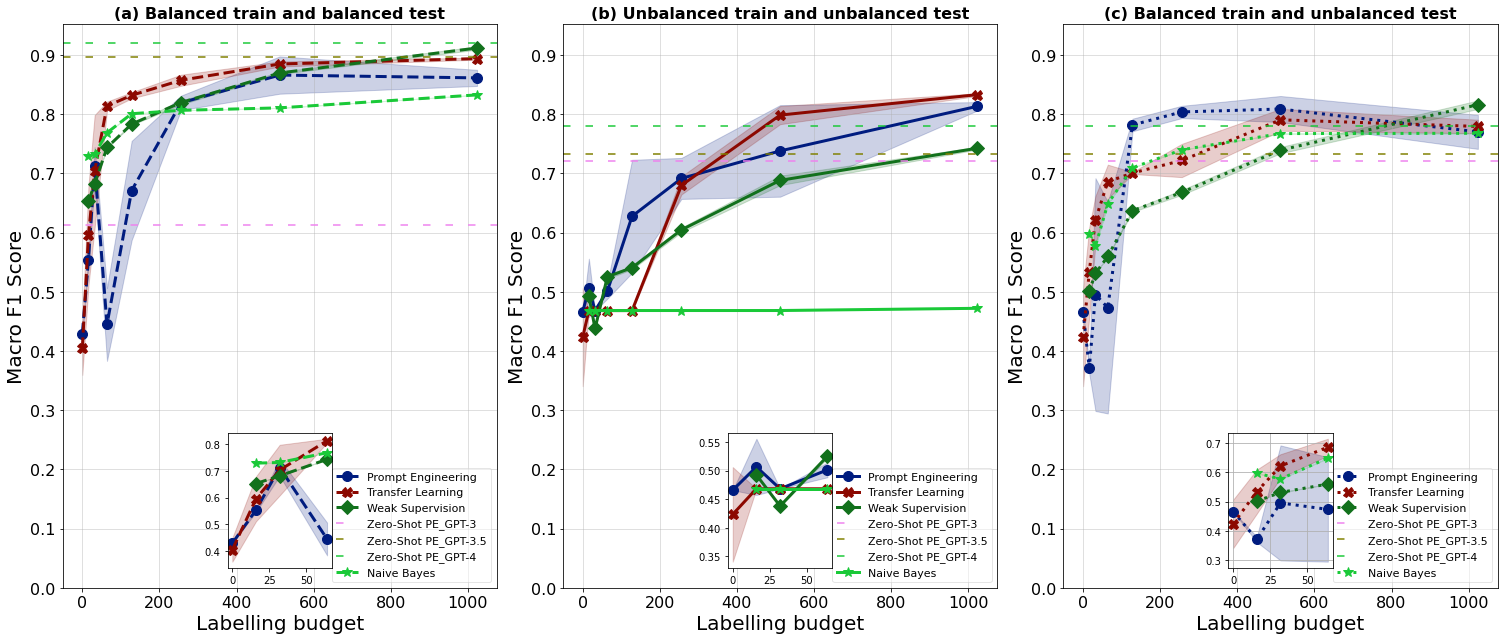

In [34]:
task = 'Binary Abuse'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel',
                     'Zero Shot Prompt Engineering':'GPT-3',
                     'Naive Bayes':'Naive Bayes'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain abuse?'
fixed_prompt_zp = 'Using one word, does the internet comment contain toxic language, Yes or No?'
y_var= 'f1'

plot_learning_curves_inset('multi panel', exp_df, techniques_models, task, y_var,
                    colors, linestyles, markers, figure_orders,
                    alpha_mean, min_alpha, threshold, fixed_prompt, fixed_prompt_zp)
 

/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_df = plot_df[(plot_df['technique']==tech)&
/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_df = plot_df[(plot_df['technique']==tech)&
/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_df = plot_df[(plot_df['technique']==tech)&
/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_df = plot_df[(plot_df['technique']==tech)&(plot_df['model']==techniques_models[tech])&(plot_df['balanced_eval']==balanced[1][0])&
/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_16269/104544772.py:39:

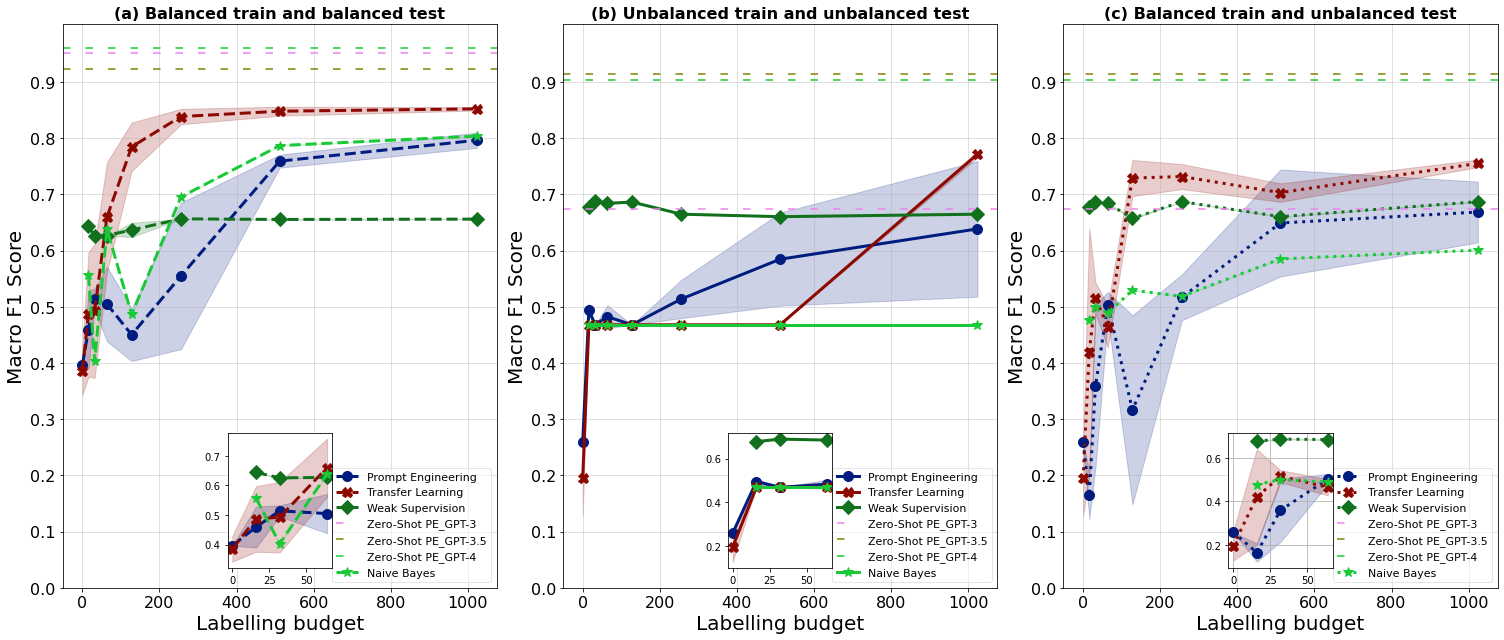

In [35]:
task = 'Binary Movie Sentiment'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel',
                     'Zero Shot Prompt Engineering':'GPT-3',
                     'Naive Bayes':'Naive Bayes'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain negative sentiment?'
fixed_prompt_zp = 'Using one word, does the movie review contain negative sentiment, Yes or No?'
y_var= 'f1'

plot_learning_curves_inset('multi panel', exp_df, techniques_models, task, y_var,
                    colors, linestyles, markers, figure_orders,
                    alpha_mean, min_alpha, threshold, fixed_prompt, fixed_prompt_zp)
 

### All Techniques (training time)

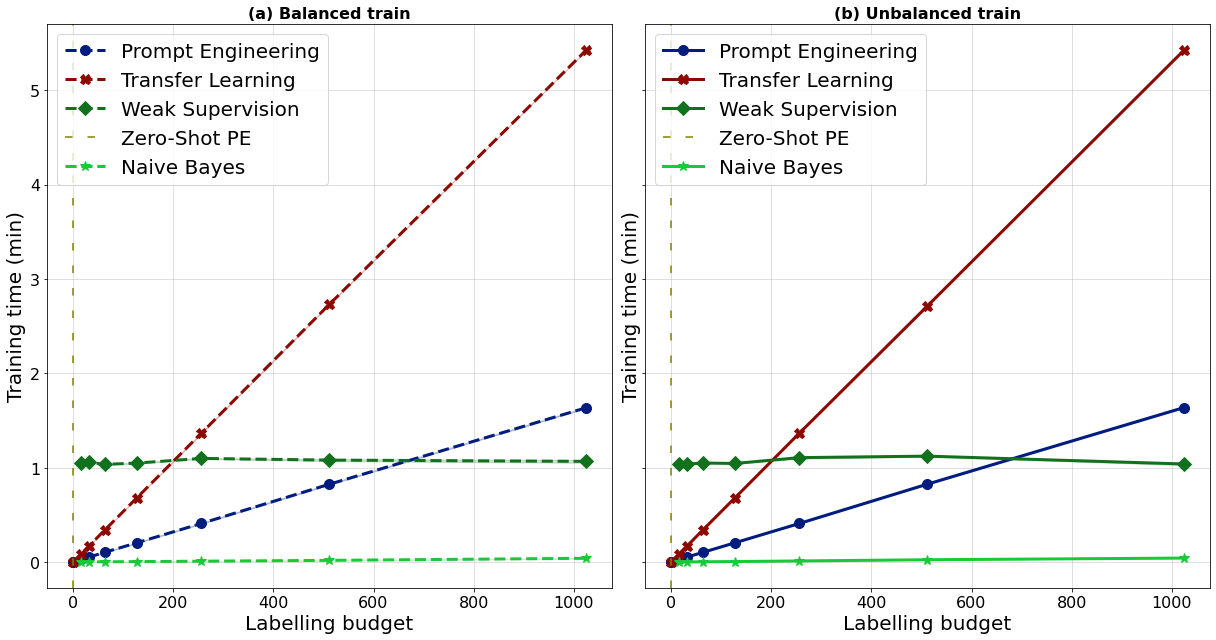

In [108]:
task = 'Binary Abuse'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel',
                     'Zero Shot Prompt Engineering':'GPT-3.0',
                     'Naive Bayes':'Naive Bayes'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain abuse?'
fixed_prompt_zp = 'Using one word, does the movie review contain negative sentiment, Yes or No?'
var= 'train_runtime'

plot_learning_curves('multi panel', exp_df, techniques_models, task, var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'upper left', fixed_prompt, fixed_prompt_zp)

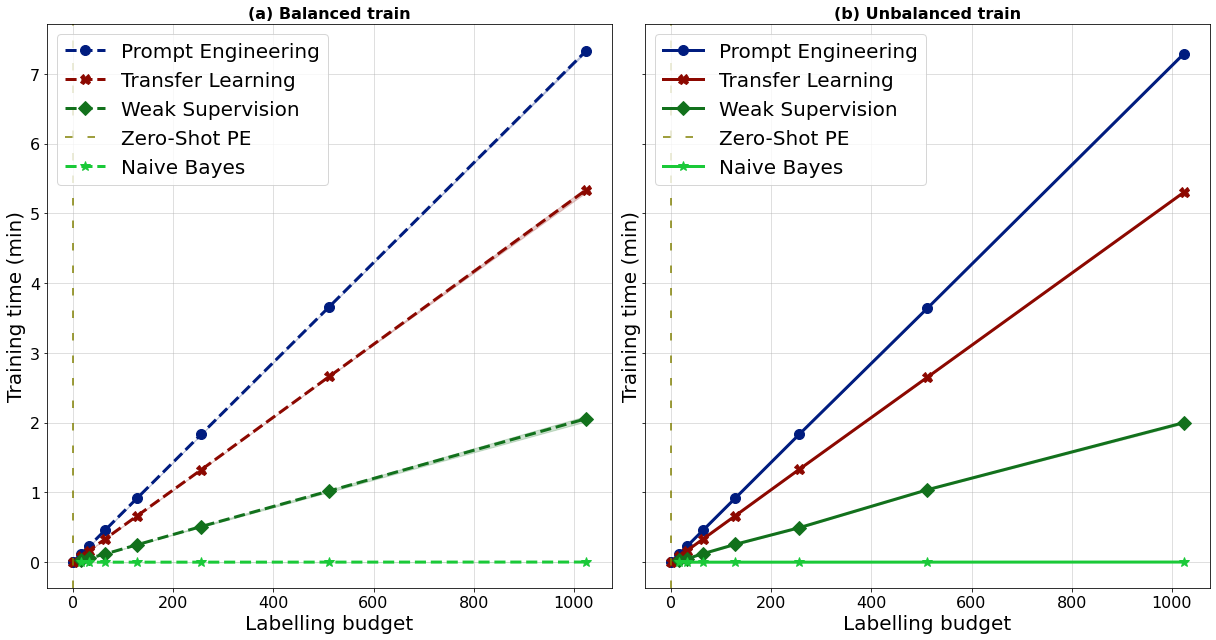

In [69]:
task = 'Binary Movie Sentiment'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel',
                      'Zero Shot Prompt Engineering':'GPT-3.0',
                      'Naive Bayes':'Naive Bayes'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain negative sentiment?'
fixed_prompt_zp = 'Using one word, does the movie review contain negative sentiment, Yes or No?'
var= 'train_runtime'

plot_learning_curves('multi panel', exp_df, techniques_models, task, var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'upper left', fixed_prompt, fixed_prompt_zp)

# Plot Single Technique By Split Var


In [109]:
#TODO: Have version of graph where you can specify a lower n-train cutoff


def plot_learning_curves_by_split_var_multi(PLOT_TYPE, exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold):

    plot_df = exp_df[(exp_df['technique']==technique)]
    fixed_var_dict = base_variable_values[technique]
    for col, fixed_v in fixed_var_dict.items():
        if col!=split_var:
            plot_df = plot_df[plot_df[col].isin(fixed_v)]
    values = plot_df[split_var].unique()
    task = base_variable_values[technique]['task'][0]

    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (12,8))
        single_ax.set_title(f'{technique} by {split_var.capitalize()}', fontweight = 'semibold', fontsize = 18)
    else:
        multi_fig, multi_ax = plt.subplots(1,3, figsize = (21,8), sharey = True)
    balanced_train_eval_type = [[(True, "Balanced"), (True, "balanced")], [(False, "Unbalanced"), (False, "unbalanced")], [(True, "Balanced"), (False, "unbalanced")]] #[(train_type, train_label), (eval_type, eval_label)]
    for i,val in enumerate(values):
        for j, balanced in enumerate(balanced_train_eval_type):
            # Subset dataframe
            line_df = plot_df[(plot_df[split_var]==val)&(plot_df['balanced_eval']==balanced[1][0])
                              &(plot_df['balanced_train']==balanced[0][0])
                              ]
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                label = f'{val} ({balanced[1]})'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(f'{figure_orders[j]} {balanced[0][1]} train and {balanced[1][1]} test', fontweight = 'semibold', fontsize = 16)
                label = val
                color = colors[i][0]

            # Plot contents
            ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
            if split_var == 'template':
                ax.legend(loc='lower right', ncol = 1, fontsize = 11)
            else:
                ax.legend(loc='lower right', ncol = 1, fontsize = 20)
            alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
            ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
            # Plot features
            ax.grid(alpha=0.5)

            # Axis properties
            ax.tick_params(axis = 'both', labelsize=16)
            ax.set_xlabel('Training points', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)
            ax.yaxis.set_tick_params(labelbottom=True)

    plt.tight_layout()
    plt.show()

In [110]:
# SET FIXED VALUES
base_variable_values = {'Prompt Engineering':{'task': ['Binary Abuse'],
                        'template': ['Prompt 2: Does this text contain abuse?',
                                    'Prompt 2: Does this text contain negative sentiment?',
                                     ],
                        'model':['DistilBERT', 'GPT-2']},

                        'Transfer Learning':{'task': ['Binary Abuse'],
                        'model':['DistilBERT', 'DeBERTa-v3']},

                        'Weak Supervision':{'task': ['Binary Abuse'],
                        'model':['LabelModel']},


}

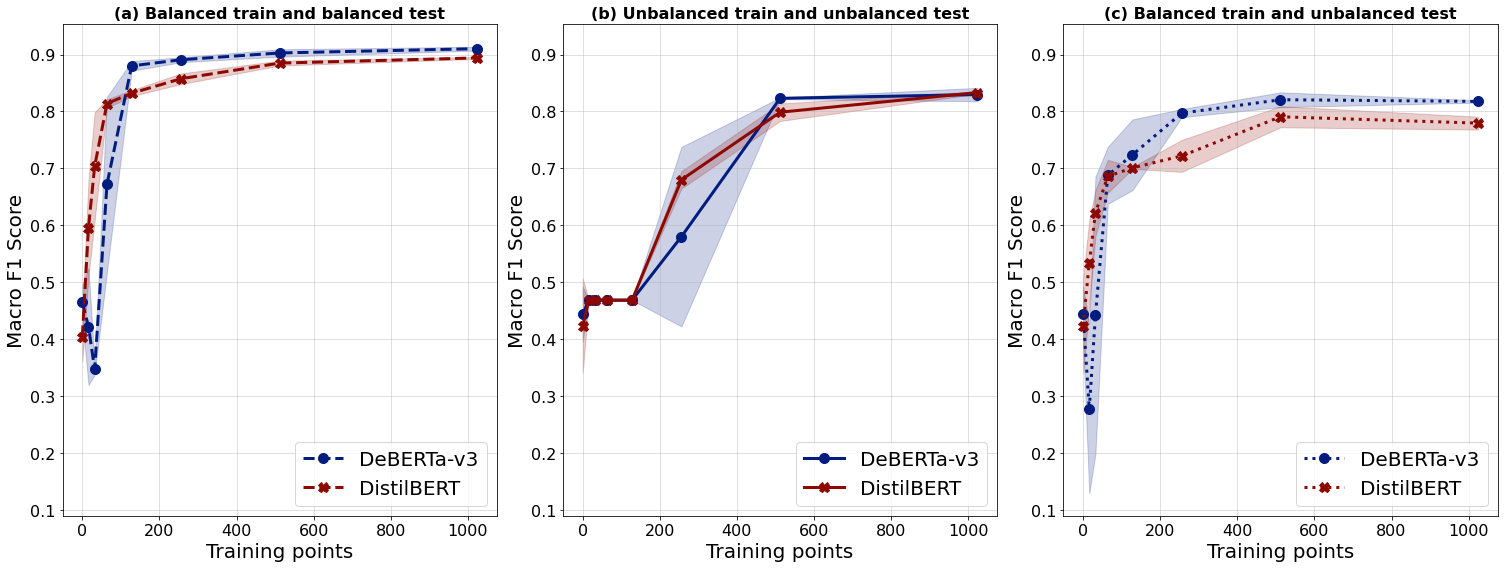

In [111]:
split_var = 'model'
y_var = 'f1'
technique = 'Transfer Learning'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

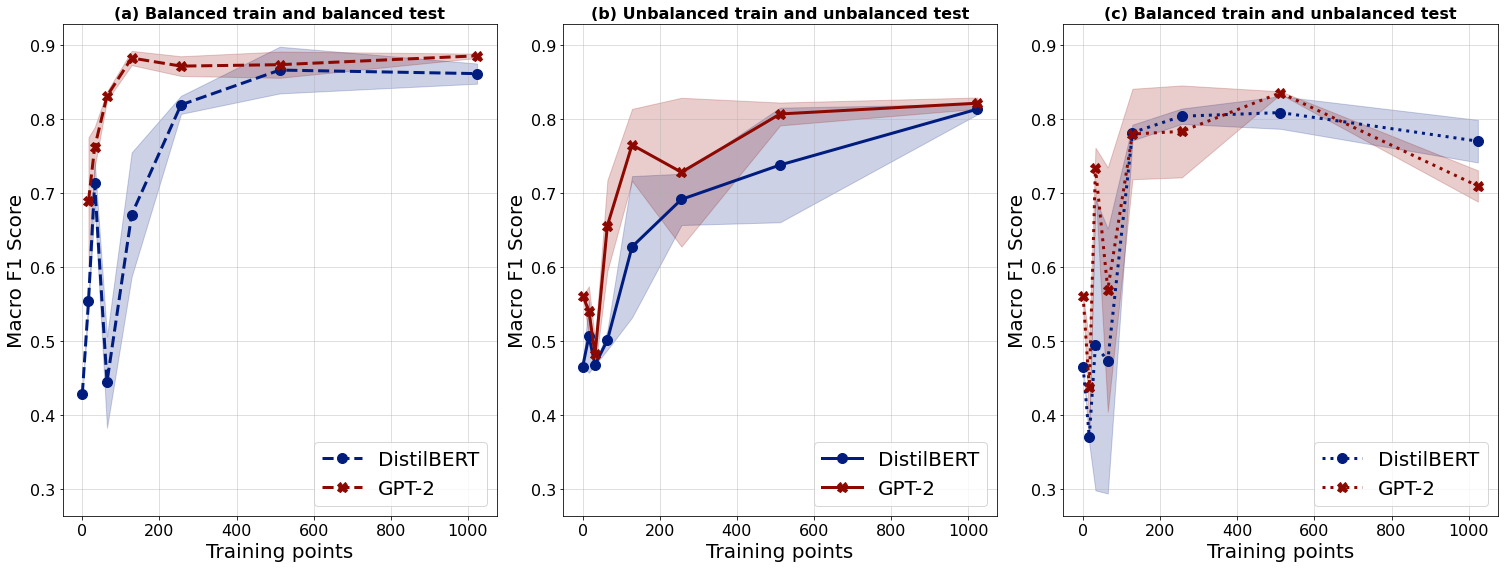

In [112]:
split_var = 'model'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

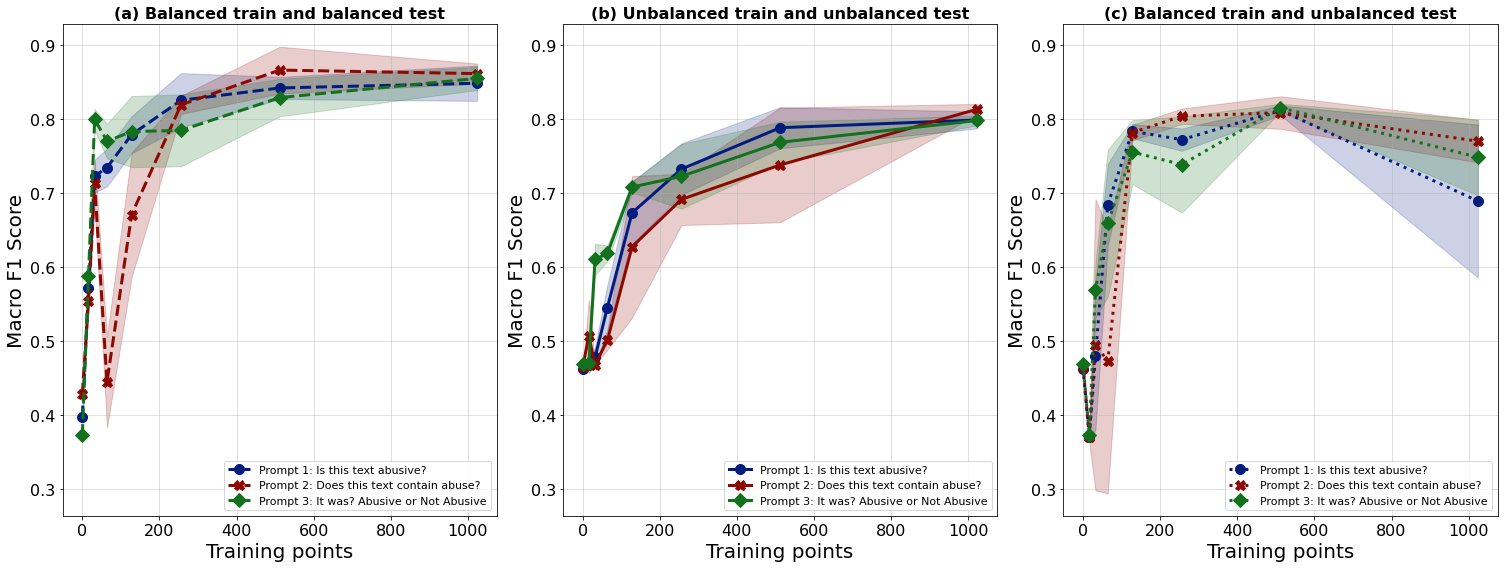

In [113]:
split_var = 'template'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

In [114]:
# SET FIXED VALUES
base_variable_values = {'Prompt Engineering':{'task': ['Binary Movie Sentiment'],
                        'template': ['Prompt 2: Does this text contain negative sentiment?',
                                     ],
                        'model':['DistilBERT']},

                        'Transfer Learning':{'task': ['Binary Movie Sentiment'],
                        'model':['DistilBERT']},

                        'Weak Supervision':{'task': ['Binary Movie Sentiment'],
                        'model':['LabelModel']},


}

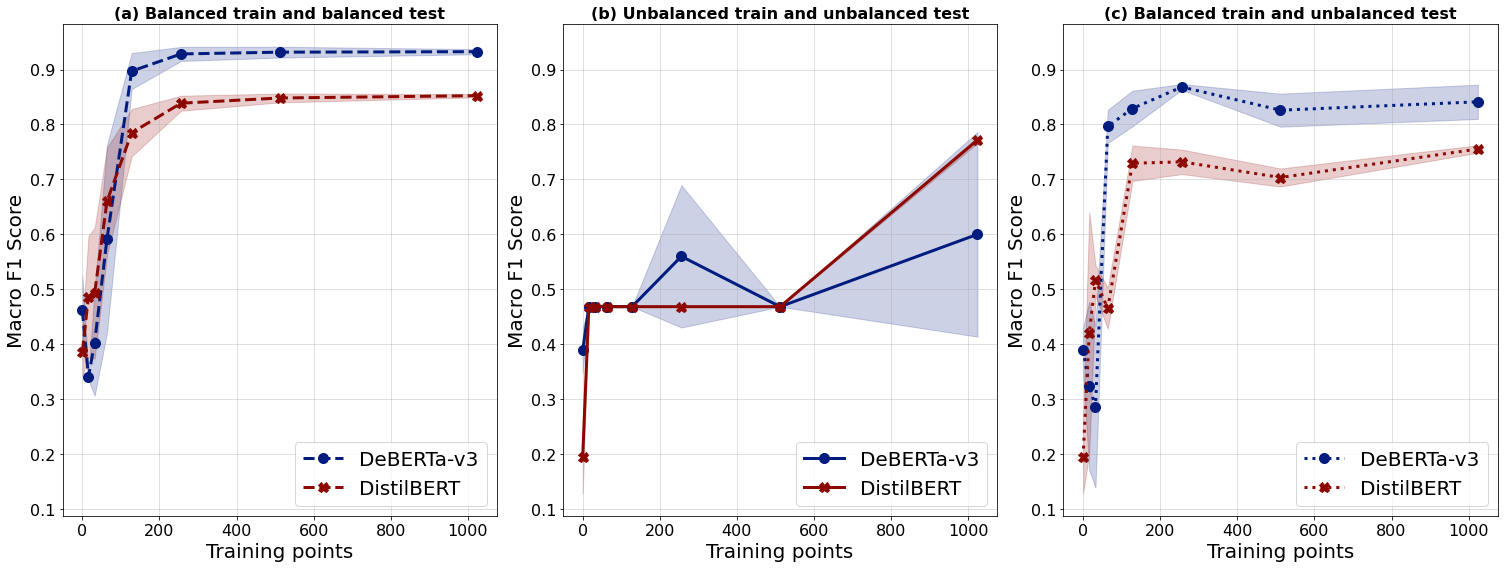

In [115]:
split_var = 'model'
y_var = 'f1'
technique = 'Transfer Learning'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

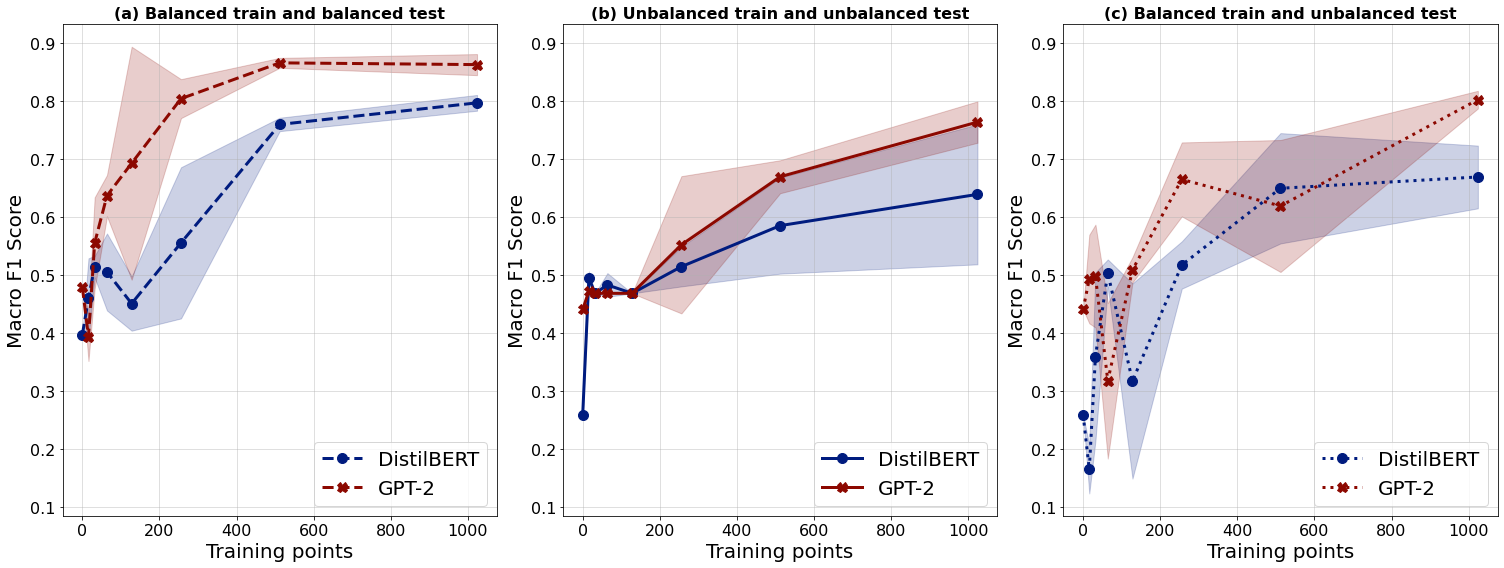

In [116]:
split_var = 'model'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

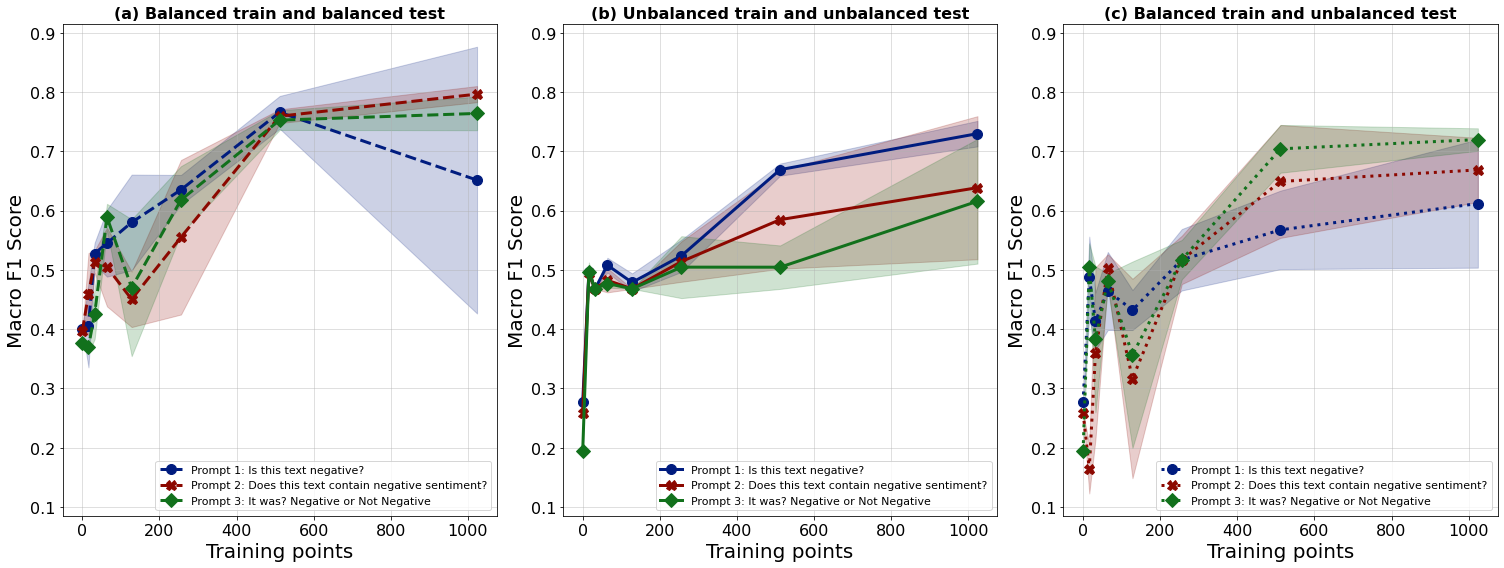

In [117]:
split_var = 'template'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)